# Churn Modelling with Neural Networks!#
<p>In this notebook, I have made a Artificial Neural Network from scratch and used it for churn modelling. Every detail of a neural network is explained with a tutorial on how to perform churn modelling "<i>correctly</i>". Churn modelling is a very sofisticated task and needs a lot of attention on choosing the metric for optimization. A very common mistake that practitioners do is choosing the accuracy as optimizing metric. It is explained in this notebook which metric is best for churn modelling and which machine learning architectures to use for the purpose. </p>
<p> I have used the dataset openly available on SuperDataScience website. It contains data of 10,000 customers (of course, it's synthetic). I have performed EDA and Feature Engineering openly available on Tableau Public Website. The details of data cleaning step is given in the Data Science Notebook.</p>

### 1. Importing the Libraries ###
<p> We will use numpy for doing matrix algebra, matplotlib to plot graphs(of course!), pandas to read our dataset, sklearn to clean and preprocess our dataset. warnings, time, os, and sys have been used rarely. ProcessPoolExecutor is used to perform parallelism and train multiple models on seperate CPUs. 

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import warnings
import time
import os
import sys
from concurrent.futures import ProcessPoolExecutor as ppe
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
# Setting up the environment
warnings.filterwarnings('ignore')
os.system("CLS")
%matplotlib inline

### 2. Importing our Dataset.###
<p> We have imported the dataset and split it into a training, test and dev sets. Further, we have removed unwanted features and normalized the remaining features. Categorical features have been OneHot Encoded.</p>
<p><strong>Notice</strong>: We have taken the transpose of training, test, and dev sets. It is because, we want the datasets to have shape (m,n) where m are the number of examples and n are the number of features. Most of the open source libs use the (n,m) shape but for our simplicity, the shapes have been altered. 

In [3]:
# Getting our dataset
os.chdir("C:\\Users\\Hilak\\Desktop\\INTERESTS\\Machine Learning A-Z Template Folder\\Part 8 - Deep Learning\\Section 39 - Artificial Neural Networks (ANN)");
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, [13]].values

# Encoding categorical data
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_test, X_CV, y_test, y_CV = train_test_split(X_test, y_test, test_size = 0.5)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_CV = sc.transform(X_CV)

# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components = 2, kernel="rbf")
# X_train = kpca.fit_transform(X_train)
# X_test = kpca.transform(X_test)

X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T
X_CV = X_CV.T
y_CV = y_CV.T

### Problem statement : This dataset contains the data of customers of a bank. The bank has hired you as a data scientist to predict if the customer will stay with the bank or leave. ###
<p><li>Total no. of examples in the dataset     : 10000</li>
<li>No. of examples in the training set      : 8000</li>
<li>No. of examples in the test set          : 1000</li>
<li>No. of examples in the CV set            : 1000</li></p>

## 3. Our Neural Network ##
<p> Now, let's proceed to make our Artificial Neural Network and some more interesting stuff for our modelling.</p>
<p> To understand the neural networks is a pretty hard job and only coding them clears most of the subtle concepts that we may have missed or ignored during reading about them or watching a tutorial or a course video. I have written a comment in every line explaining each of them. I have written an <a href="#">article on this implementation</a> on Medium if you are interested having a look at it.</p>
<p> Let me explain in brief, what features have I implemented in this code.</p>
<ol>
    <li><p><i>NeuralNet(layers, X, y, ac_funcs, init_method, loss_func)</i> to initialize our network.</p></li>
    <li><p><i>NeuralNet.startTraining(batch_size, epochs, alpha, decay_rate, _lambda, keep_prob, threshold, beta1, beta2, interval, print_metrics, evaluate, X_test, y_test)</i> to start training our network.</p></li>
    <li><p><i>NeuralNet.predict(X_test)</i> to predict on a test set.</p></li>
    <li><p><i>NeuralNet.plot_decision_boundary(X_set, y_set, title, xlab, ylab)</i> to plot the dicision boundary in case you have only two features. Note: The dataset must have two features.</p></li>
</ol>
<p>I have also implemented HyperParameterTuning techniques like GridSearch and RandomizedGridSearch. You can go ahead and take a look at them by yourself as there are no comments to explain it but, don't worry, it's pretty straight-forward.

In [4]:
def sigmoid(z) :
    """ Reutrns the element wise sigmoid function. """
    return 1./(1 + np.exp(-z))
def sigmoid_prime(z) :
    """ Returns the derivative of the sigmoid function. """
    return sigmoid(z)*(1-sigmoid(z))
def ReLU(z) : 
    """ Reutrns the element wise ReLU function. """
    return (z*(z > 0))
def ReLU_prime(z) :
    """ Returns the derivative of the ReLU function. """
    return 1*(z>=0)
def lReLU(z) : 
    """ Reutrns the element wise leaky ReLU function. """
    return np.maximum(z/100,z)
def lReLU_prime(z) :
    """ Returns the derivative of the leaky ReLU function. """
    z = 1*(z>=0)
    z[z==0] = 1/100
    return z
def tanh(z) :
    """ Reutrns the element wise hyperbolic tangent function. """
    return np.tanh(z)
def tanh_prime(z) : 
    """ Returns the derivative of the tanh function. """
    return (1-tanh(z)**2)
def softmax(z) :
    t = np.exp(z)
    return (t/np.sum(t,axis=0))
def softmax_prime(z):
    return softmax(z)*(1-softmax(z))
    

# A dictionary of our activation functions
PHI = {'sigmoid':sigmoid, 'relu':ReLU, 'lrelu':lReLU, 'tanh':tanh, 'softmax':softmax}

# A dictionary containing the derivatives of our activation functions
PHI_PRIME = {'sigmoid':sigmoid_prime, 'relu':ReLU_prime, 'lrelu':lReLU_prime, 'tanh':tanh_prime, 'softmax':softmax_prime}


class NeuralNet : 
    """
    This is a class for implementing Artificial Neural Networks. L2 and Droupout are the 
    default regularization methods implemented in this class. It takes the following parameters:
    
    1. layers      : A python list containing the different number of neurons in each layer.
                     (containing the output layer)
                     Eg - [64,32,16,16,1]
                
    2. X           : Matrix of features with rows as features and columns as different examples.
    
    3. y           : Numpy array containing the ouputs of coresponding examples.
    
    4. ac_funcs    : A python list containing activation function of each layer.
                     Eg - ['relu','relu','lrelu','tanh','sigmoid']
    
    5. init_method : Meathod to initialize weights of the network. Can be 'gaussian','random','zeros'.
    
    6. loss_func   : Currently not implemented
    
    7. W           : Weights of a pretrained neural network with same architecture.
    
    8. B           : Biases of a pretrained neural network with same architecture.
    """
    def __init__(self, layers, X, y, ac_funcs, init_method='xavier', loss_func='b_ce', W=np.array([]), B=np.array([])) :
        """ Initialize the network. """
        # Store the layers of the network
        self.layers = layers
        # ----
        self.W = None
        self.B = None
        # Store the number of examples in the dataset as m
        self.m = X.shape[1]
        # Store the full layer list as n
        self.n = [X.shape[0], *layers]
        # Save the dataset
        self.X = X
        # Save coresponding output
        self.y = y
        self.X_mini = None
        self.y_mini = None
        self.m_mini = None
        # List to store the cost of the model calculated during training
        self.cost = []
        # Stores the accuracy obtained on the test set.
        self.acc = 0
        # Activation function of each layer
        self.ac_funcs = ac_funcs
        self.loss = loss_func
        # Initialize the weights by provided method.
        if len(W) and len(B) :
            self.W = W
            self.B = B
        else : 
            if init_method=='xavier': 
                self.W = [np.random.randn(self.n[nl], self.n[nl-1])*np.sqrt(2/self.n[nl-1]) for nl in range(1,len(self.n))]
                self.B = [np.zeros((nl,1), 'float32') for nl in self.layers]
            elif init_method=='gaussian': 
                self.W = [np.random.randn(self.n[nl], self.n[nl-1]) for nl in range(1,len(self.n))]
                self.B = [np.zeros((nl,1), 'float32') for nl in self.layers]
            elif init_method == 'random':
                self.W = [np.random.rand(self.n[nl], self.n[nl-1]) for nl in range(1,len(self.n))]
                self.B = [np.random.rand(nl,1) for nl in self.layers]
            elif init_method == 'zeros':
                self.W = [np.zeros((self.n[nl], self.n[nl-1]), 'float32') for nl in range(1,len(self.n))]
                self.B = [np.zeros((nl,1), 'float32') for nl in self.layers]
        self.vdw = [np.zeros(i.shape) for i in self.W]
        self.vdb = [np.zeros(i.shape) for i in self.B]
        self.sdw = [np.zeros(i.shape) for i in self.W]
        self.sdb = [np.zeros(i.shape) for i in self.B]
    
    def startTraining(self, batch_size, epochs, alpha, decay_rate, _lambda, keep_prob, threshold=0.5, beta1=0.9, beta2=0.999, interval=10, print_metrics = True, evaluate=False, X_test=None, y_test=None):
        """
        Start training the neural network. It takes the followng parameters : 
        
        1. batch_size : Size of your mini batch. Must be greater than 1.
        
        2. epochs         : Number of epochs for which you want to train the network.
        
        3. alpha          : The learning rate of your network.
        
        4. decay_rate     : The rate at which you want to decrease your learning rate.

        5. _lambda        : L2 regularization parameter or the penalization parameter.

        6. keep_prob      : Python List. Dropout regularization parameter. The percentage of neurons to keep activated.
                            Eg - 0.8 means 20% of the neurons have been deactivated.

        7. threshold      : Threshold for binary classification
        
        8. beta1          : Momentum. default=0.9
        
        9. beta2          : RMSprop Parameter. default=0.999
        
        10. interval      : The interval between updates of cost and accuracy. default=10

        11. print_metrics : Boolean. Controls printing of metrics. default=True

        12. evaluate      : Boolean. True if you want to evaluate your model on a test set. default=False

        13. X_test        : Test set to be provided if evaluate=True.

        14. y_test        : Labels coresponding to the test set. 
        """
        dataset_size = self.X.shape[1]                                                                                                                                                  # Store the dataset size.
        k=1                                                                                                                                                                             # Step.
        cost_val = 0                                                                                                                                                                    # Variable to store the value of cost while we are training our network.
        for j in range(1, epochs+1):                                                                                                                                                    # Looping epochs no. of times.
            start = time.time()                                                                                                                                                         # Starting to train a mini_batch.
            alpha = alpha/( 1 + decay_rate*(j-1) )                                                                                                                                      # Decaying learning rate after every epoch.
            for i in range(0, dataset_size-batch_size+1, batch_size):                                                                                                                   # Loop to devide the dataset into mini_batches and training each of them.
                self.X_mini = self.X[:, i:i+batch_size]                                                                                                                                 # Slicing dataset into one mini_batch.
                self.y_mini = self.y[:, i:i+batch_size]                                                                                                                                 # Slicing coresponding labels.
                self.m_mini = self.y_mini.shape[1]                                                                                                                                      # Storing the number of examples in the mini_batch. Used later during calculation of cost derivative.
                self._miniBatchTraining(alpha, beta1, beta2, _lambda, keep_prob,k)                                                                                                      # Training a single mini_batch.
                if not k%interval:                                                                                                                                                      # Print metrics after every interval.
                    aa = self.predict(self.X)                                                                                                                                           # Predicting on our dataset.
                    if self.loss == 'b_ce':                                                                                                                                             # Handing metrics for binary classification.
                        aa_ = aa > threshold                                                                                                                                            # Thresholding.
                        self.acc = np.sum(aa_ == self.y) / self.m                                                                                                                       # Calculating the accuracy achieved on the training_set.
                        cost_val = self._cost_func(aa, _lambda)                                                                                                                         # Calculating the value of cost function.
                        self.cost.append(cost_val)                                                                                                                                      # Logging it in the list of cost values.
                    elif self.loss == 'c_ce':                                                                                                                                           # Haldling metrics for categorical classification.
                        aa_ = np.argmax(aa, axis = 0)                                                                                                                                   # Getting the label of our prediction.
                        yy = np.argmax(self.y, axis = 0)                                                                                                                                # Getting the correct label.
                        self.acc = np.sum(aa_==yy)/(self.m)                                                                                                                             # Comparing our predictions with correct labels.
                        cost_val = self._cost_func(aa, _lambda)                                                                                                                         # Calculating the value of cost function.
                        self.cost.append(cost_val)                                                                                                                                      # Logging it in the list of cost values.
                if print_metrics:                                                                                                                                                       # If the user wants to print the metrics, print them.
                    sys.stdout.write(f'\rEpoch[{j}] {i+batch_size}/{self.m} : Cost = {cost_val:.4f} ; Acc = {(self.acc*100):.2f}% ; Time Taken = {(time.time()-start):.0f}s')           # Print the metrics.
                k+=1                                                                                                                                                                    # Increment the step by one.
            print('\n')                                                                                                                                                                 # Line Break.
        if evaluate:                                                                                                                                                                    # Checking if the user wants to evaluate the model on a test set.
            print(f"For batch_size = {batch_size}, epochs = {epochs}, alpha = {alpha}, decay_rate = {decay_rate}, _lambda = {_lambda}, keep_prob = {keep_prob}")                        # Print the values of hyperparameters.
            aa = self.predict(X_test)                                                                                                                                                   # Predicting the labels of test set.
            if self.loss == 'b_ce':                                                                                                                                                     # Handling the metrics for binary classification.
                aa_ = aa > threshold                                                                                                                                                    # Thresholding.
                acc = np.sum(aa_ == y_test) / X_test.shape[1]                                                                                                                           # Calculating the accuracy achieved on the test set.
                print(f"Accuracy on training set: {self.acc}")                                                                                                                          # Print the accuracy achieved on the training_set.
                print(f"Accuracy on test set: {acc}\n")                                                                                                                                 # Print the accuracy achieved on the test set.
            elif self.loss == 'c_ce':                                                                                                                                                   # Handling the metrics for categorical classification.
                aa_ = np.argmax(aa, axis = 0)                                                                                                                                           # Getting the label of our prediction.
                yy = np.argmax(y_test, axis = 0)                                                                                                                                        # Getting the correct label.
                acc = np.sum(aa_==yy)/(X_test.shape[1])                                                                                                                                 # Comparing our predictions with correct labels.
                print(f"Accuracy on training set: {self.acc}")                                                                                                                          # Print the accuracy achieved on the training_set.
                print(f"Accuracy on test set: {acc}\n")                                                                                                                                 # Print the accuracy achieved on the test set.
        
    
    def _miniBatchTraining(self, alpha, beta1, beta2, _lambda, keep_prob,i):
        epsilon = 1e-8
        z,a = self._feedForward(keep_prob)
        delta = self._cost_derivative(a[-1])
        for l in range(1,len(z)) : 
            delta_w = (1/self.m_mini)*(np.dot(delta, a[-l-1].T) + (_lambda)*self.W[-l])
            delta_b = (1/self.m_mini)*(np.sum(delta, axis=1, keepdims=True))
            self.vdw[-l] = (beta1*self.vdw[-l] + (1-beta1)*delta_w)
            vdw_corrected = self.vdw[-l]/(1 - beta1**i)
            self.vdb[-l] = (beta1*self.vdb[-l] + (1-beta1)*delta_b)
            vdb_corrected = self.vdb[-l]/(1 - beta1**i)
            self.sdw[-l] = (beta2*self.sdw[-l] + (1-beta2)*(delta_w**2))
            sdw_corrected = self.sdw[-l]/(1 - beta2**i)
            self.sdb[-l] = (beta2*self.sdb[-l] + (1-beta2)*(delta_b**2))
            sdb_corrected = self.sdb[-l]/(1 - beta2**i)
            delta = np.dot(self.W[-l].T, delta)*PHI_PRIME[self.ac_funcs[-l-1]](z[-l-1])
            self.W[-l] = self.W[-l] - (alpha)*(vdw_corrected/(np.sqrt(sdw_corrected)+epsilon))
            self.B[-l] = self.B[-l] - (alpha)*(vdb_corrected/(np.sqrt(sdb_corrected)+epsilon))
        delta_w = (1/self.m_mini)*(np.dot(delta, self.X_mini.T ) + (_lambda)*self.W[0])
        delta_b = (1/self.m_mini)*(np.sum(delta, axis=1, keepdims=True))
        self.vdw[0] = (beta1*self.vdw[0] + (1-beta1)*delta_w)
        vdw_corrected = self.vdw[0]/(1 - beta1**i)
        self.vdb[0] = (beta1*self.vdb[0] + (1-beta1)*delta_b)
        vdb_corrected = self.vdb[0]/(1 - beta1**i)
        self.sdw[0] = (beta2*self.sdw[0] + (1-beta2)*(delta_w**2))
        sdw_corrected = self.sdw[0]/(1 - beta2**i)
        self.sdb[0] = (beta2*self.sdb[0] + (1-beta2)*(delta_b**2))
        sdb_corrected = self.sdb[0]/(1 - beta2**i)
        self.W[0] = self.W[0] - (alpha)*(vdw_corrected/(np.sqrt(sdw_corrected)+epsilon))
        self.B[0] = self.B[0] - (alpha)*(vdb_corrected/(np.sqrt(sdb_corrected)+epsilon))
        return None
    
    def predict(self, X_test) :
        """ Predict the labels for a new dataset. Returns probability. """
        a = PHI[self.ac_funcs[0]](np.dot(self.W[0], X_test) + self.B[0])
        for l in range(1,len(self.layers)):
            a = PHI[self.ac_funcs[l]](np.dot(self.W[l], a) + self.B[l])
        return a
            
    
    def _feedForward(self, keep_prob):
        """ Forward pass """
        z = [];a = []
        z.append(np.dot(self.W[0], self.X_mini) + self.B[0])
        a.append(PHI[self.ac_funcs[0]](z[-1]))
        for l in range(1,len(self.layers)-1):
            z.append(np.dot(self.W[l], a[-1]) + self.B[l])
            # a.append(PHI[self.ac_funcs[l]](z[l]))
            _a = PHI[self.ac_funcs[l]](z[l])
            a.append( ((np.random.rand(*_a.shape) < keep_prob[l-1])*_a)/keep_prob[l-1] )
        z.append(np.dot(self.W[-1], a[-1]) + self.B[-1])
        a.append(PHI[self.ac_funcs[-1]](z[-1]))
        return z,a
    
    def _cost_func(self, a, _lambda):
        """ Binary Cross Entropy Cost Function """
        if self.ac_funcs[-1] == 'sigmoid':
            return ( (-1/self.m)*np.sum(np.nan_to_num(self.y*np.log(a+10e-8) + (1-self.y)*np.log(1-a+10e-8))) + (_lambda/(2*self.m))*np.sum([np.sum(i**2) for i in self.W]) )
        return ( (-1/self.m)*np.sum(np.nan_to_num(self.y*np.log(a))) + (_lambda/(2*self.m))*np.sum([np.sum(i**2) for i in self.W]) )
        
    def _cost_derivative(self, a) : 
        """ The derivative of cost w.r.t z """
        return (a-self.y_mini)

    def plot_decision_boundary(self, X_set, y_set, title='', xlab='', ylab=''):
        X_set, y_set = X_set.T, y_set.T
        X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                             np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
        preds = self.predict(np.array([X1.ravel(), X2.ravel()])).reshape(X1.shape)
        preds = 1*(preds > 0.5)
        plt.contourf(X1, X2, preds, alpha = 0.75, cmap = ListedColormap(('red', 'green')))
        plt.xlim(X1.min(), X1.max())
        plt.ylim(X2.min(), X2.max())
        for i, j in enumerate(np.unique(y_set[:,0])):
            plt.scatter(X_set[y_set[:,0] == j, 0], X_set[y_set[:,0] == j, 1],
                        c = ListedColormap(('red', 'green'))(i), label = j)
        plt.title(title)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.legend()
        plt.show()
   
    @property
    def summary(self) :
        return self.cost, self.acc, self.W,self.B
    def __repr__(self) : 
        return f'<Neural Network at {id(self)}>'


class HyperParameterTuning:

    def __init__(self, layers, X, y, ac_funcs, X_test, y_test):
        self.layers = layers
        self.X = X
        self.y = y
        self.ac_funcs = ac_funcs
        self.X_test = X_test
        self.y_test = y_test
        

    def GridSearch(self, params):
        if __name__ == '__main__':
            models=[]
            with ppe(max_workers = len(params)) as pool:
                for param in params:
                    models.append(NeuralNet(self.layers, self.X, self.y, self.ac_funcs))
                    pool.submit(models[-1].startTraining, batch_size=param['batch_size'], epochs=param['epochs'], alpha=param['alpha'], decay_rate=param['decay_rate'], _lambda=param['_lambda'], keep_prob=param['keep_prob'], print_metrics=False, evaluate=True, X_test=self.X_test, y_test=self.y_test)
        return models

    def RandomizedGridSearch(self, params_range, nb_models):
        if __name__ == '__main__':
            models = []
            params = []
            for i in range(nb_models):
                params.append({
                    'batch_size' : int(np.round(np.random.rand()*(params_range['batch_size'][1]-params_range['batch_size'][0]) + params_range['batch_size'][0])),
                    'epochs' : int(np.round(np.random.rand()*(params_range['epochs'][1]-params_range['epochs'][0]) + params_range['epochs'][0])),
                    'alpha' : 10**(np.random.rand()*(np.log10(params_range['alpha'][1])-np.log10(params_range['alpha'][0])) + np.log10(params_range['alpha'][0])),
                    'decay_rate' : 10**(np.random.rand()*(np.log10(params_range['decay_rate'][1])-np.log10(params_range['decay_rate'][0])) + np.log10(params_range['decay_rate'][0])),
                    '_lambda' : 10**(np.random.rand()*(np.log10(params_range['_lambda'][1])-np.log10(params_range['_lambda'][0])) + np.log10(params_range['_lambda'][0])),
                    'keep_prob' : [(np.random.rand()*(params_range['keep_prob'][1]-params_range['keep_prob'][0]) + params_range['keep_prob'][0]) for j in range(len(self.layers)-1)]
                    })
            with ppe(max_workers = len(params)) as pool:
                for param in params:
                    models.append(NeuralNet(self.layers, self.X, self.y, self.ac_funcs))
                    pool.submit(models[-1].startTraining, batch_size=param['batch_size'], epochs=param['epochs'], alpha=param['alpha'], decay_rate=param['decay_rate'], _lambda=param['_lambda'], keep_prob=param['keep_prob'], print_metrics=False, evaluate=True, X_test=self.X_test, y_test=self.y_test)

    def __repr__(self):
        return f'<HPT at {id(self)}>'

### 4. Using our Neural Network for Churn Modelling###
<p> Horray! We have implemented a fully vectorized Neural Network with Dropout and L2 Regularization with HyperParameterTuning as bonus. Now, we can finally use it for making all sorts of models for classification purposes. We know that, Neural Nets outperform most of the classification algorithms and is one of the most used algorithms for wide range of classification tasks. </p>
<p> We are going to use this neural network for churn modelling which is a very sophisticated classification tasks and needs a lot of micro level understanding of the data to perform it successfully.</p>
<p> We first initialize a network with two layers have 32 neurons and ReLU activation. After a lot of hyperparameter searching, I have came across 0.01 as the best learning rate with a batch_size of 500, penelization of 0.7, droprate of 90% in both the layers, and a decay_rate of 0.0001. We train our model for 100 epochs.</p>
<p> A very important hyperparameter for our task is the <i>threshold</i>. It is the bound after which we predict that the customer will leave the bank. With the threshold of 0.5 (which most of the practitioners use), we have a preety good accuracy of >85% on train, test, and dev set. But, as I have mentioned above, accuracy is not the correct optimizing metric for our task. Let us understand why. First, we have a data that says if the customer has left or stayed with the bank. It is obvious that it would be skewed (meaning there would be more negatives than positives). This dataset is 79.60% skewed i.e. 79.60% of the customers have stayed with the bank. If we have a model that just spits out 0 for any and every example we pass in, we would still have a decent accuracy of 79.60%. This shows that >85% accuracy is not "great". This has been tested and very poor results have been obtained with <40% recall and <40% F1 score. This shows that we are predicting that the customer will not leave the bank while the customer acually left the bank. But, the bank wants to retain as many customers as possible. With such a high skewness, our model has a natural bias towards 0 (or the customer never leave the bank) hence leading the bank towards a huge loss. Moreover, predicting that a customer may leave even if he actully isn't doesn't cost the bank much. Hence, we need to have recall as the optimizing metric with accuracy and F1 score as satisficing metrics. This choice of metric may vary from task to task but bear in mind that accuracy is never a good metric for churn modelling. </p>
<p> Now, to increse the recall, we need to set the threshold low enough such that it doesn't hurt the performance of the model much. Threshold has the control of how much "confidence" you need to say that the customer may leave the bank. A fair choice of confidence would be 0.5, meaning, predict that the customer leaves if we are above 50% sure. But, this arises the problem described above. Hence, by lowering the threshold, we are just saying that the customer would leave with a low confidence. This would lead to predicting that the customer would leave more often than saying that he would stay. This can lead to more false positives but it is fine for the bank as long as it retains most of its customers. </p>
<p> Having said that, let's get our first model trained</p>

In [5]:
# Initializing our neural network
neural_net = NeuralNet([32,32,1], X_train, y_train, ac_funcs = ['relu','relu','sigmoid'])
# Staring the training of our network.
neural_net.startTraining(batch_size=500, epochs=100, alpha=0.01, decay_rate=0.0001, beta1=0.9, beta2=0.999, _lambda=0.7, keep_prob=[0.9,0.9], threshold=0.25)

Epoch[1] 8000/8000 : Cost = 0.4867 ; Acc = 75.12% ; Time Taken = 0s

Epoch[2] 8000/8000 : Cost = 0.4212 ; Acc = 75.56% ; Time Taken = 0s

Epoch[3] 8000/8000 : Cost = 0.4042 ; Acc = 72.72% ; Time Taken = 0s

Epoch[4] 8000/8000 : Cost = 0.3725 ; Acc = 77.35% ; Time Taken = 0s

Epoch[5] 8000/8000 : Cost = 0.3497 ; Acc = 80.77% ; Time Taken = 0s

Epoch[6] 8000/8000 : Cost = 0.3442 ; Acc = 81.12% ; Time Taken = 0s

Epoch[7] 8000/8000 : Cost = 0.3384 ; Acc = 81.77% ; Time Taken = 0s

Epoch[8] 8000/8000 : Cost = 0.3367 ; Acc = 81.96% ; Time Taken = 0s

Epoch[9] 8000/8000 : Cost = 0.3334 ; Acc = 82.30% ; Time Taken = 0s

Epoch[10] 8000/8000 : Cost = 0.3311 ; Acc = 82.09% ; Time Taken = 0s

Epoch[11] 8000/8000 : Cost = 0.3296 ; Acc = 82.39% ; Time Taken = 0s

Epoch[12] 8000/8000 : Cost = 0.3288 ; Acc = 82.60% ; Time Taken = 0s

Epoch[13] 8000/8000 : Cost = 0.3276 ; Acc = 82.62% ; Time Taken = 0s

Epoch[14] 8000/8000 : Cost = 0.3260 ; Acc = 83.05% ; Time Taken = 0s

Epoch[15] 8000/8000 : Cost = 

<p> We are still getting a good accuracy of over 80% with threshold as low as 25%! (which is awesome!) Now, let's see how the cost of the network decreased during training and then move forward to evaluate our model on a test set.</p>

### 5. Plotting our results! ###
<p> As seen, we trained a pretty good network and it's the time to see if our implementation was correct. If the cost consistently decreases with a little bit of noise than our implemetation is perfect! Otherwise, we need to go back to see which mistakes have we made.</p>

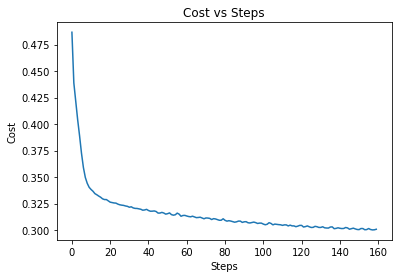

In [6]:
# Plotting our cost vs epochs relationship
summary = neural_net.summary
plt.plot(range(len(summary[0])), summary[0])
plt.title('Cost vs Steps')
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.show()

As we can see, the cost does consistently decrease with a little bit of noise at the end. This means our implemetation is correct and we have sucessfully trained a network to perform churn predictions!

### 6. Evaluating our Model ###
<p> Having trained our first neural network, let's see how good it does on the test set. We have had a lot of disscussion on the metric to use to evaluate our model and finally choose 'recall' as our optimizing metric. After training a lot of networks, below is the result I obtained as the most optimized one.</p>

In [7]:
y_pred = 1*(neural_net.predict(X_test) > 0.25)
print(classification_report(y_test.T, y_pred.T))

             precision    recall  f1-score   support

          0       0.91      0.84      0.87       769
          1       0.57      0.72      0.63       231

avg / total       0.83      0.81      0.82      1000



As we can see, we have obtained a pretty high recall with high enough F1 score and precision. Now, let's proceed ahead to evaluate our dev set.

In [8]:
y_pred = 1*(neural_net.predict(X_CV) > 0.25)
print(classification_report(y_CV.T, y_pred.T))

             precision    recall  f1-score   support

          0       0.92      0.84      0.88       805
          1       0.51      0.71      0.59       195

avg / total       0.84      0.81      0.82      1000



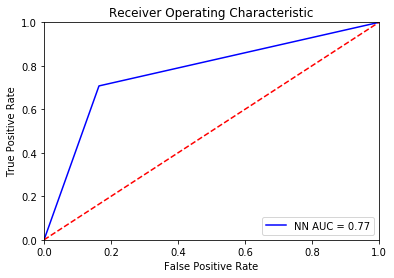

In [9]:
# Stolen form Stack Overflow
fpr, tpr, threshold = roc_curve(y_CV.T, y_pred.T)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = f'NN AUC = {roc_auc:.2f}')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As we can see, the recall for both test and dev sets are pretty high and has barely hurt the performance of the network. We also get a good AUC curve which shows that our model is pretty good. You can further improve the network to increase the recall of the model and maintain all other satisficing metrics. There are a lot of ways to do it, out of which, I choose the way I really liked. There are more powerful classifiers for churn modelling like naive bayes and logistic regression. Try them out and most importantly... Peace Out!